The data is from: 

Mahesh Joshi, Dipanjan Das, Kevin Gimpel, and Noah A. Smith. Movie Reviews and Revenues: An Experiment in Text Regression. In Proceedings of the North American Chapter of the Association for Computational Linguistics Human Language Technologies Conference, Los Angeles, CA, June 2010.

In [2]:
%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
import spacy.en
import seaborn as sns
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/Users/kesslej/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
nlp = spacy.en.English()

In [8]:
def draw_corpus(df, corpus, category, other_category, category_col, extra='', scores=None, 
                singleScoreMode=False, minimum_term_frequency=2, term_ranker=st.termranking.AbsoluteFrequencyRanker):
    html = st.produce_scattertext_explorer(corpus, 
                                           category=category, 
                                           category_name=category.lower() +' Term', 
                                           not_category_name=other_category.lower() + ' Term',
                                           pmi_filter_thresold=3,
                                           minimum_term_frequency=minimum_term_frequency,
                                           metadata=df['metadata'],
                                           scores=scores,
                                           width_in_pixels=1000,
                                           singleScoreMode=singleScoreMode,
                                           use_full_doc = False,
                                           term_ranker=term_ranker)
    file_name = category.lower() + '-' + other_category.lower() + extra + '.html'
    open(file_name, 'wb').write(html.encode('utf-8'))
    return IFrame(src=file_name, width = 1200, height=1000)

def draw_plot(df, category, other_category, category_col, extra='', term_ranker=st.termranking.AbsoluteFrequencyRanker,minimum_term_frequency=3):
    category_vs_other_df = df[(df[category_col] == category) | (df[category_col] == other_category)]
    corpus = st.CorpusFromPandas(category_vs_other_df, 
                                 category_col = category_col, 
                                 text_col = 'text',
                                 nlp = nlp).build()
    return draw_corpus(category_vs_other_df, corpus, category, other_category, category_col, extra=extra, term_ranker=term_ranker, minimum_term_frequency=minimum_term_frequency)

# Let's read the data and only look at the training set, and see that PG-13 movies have a large variance in revenue

In [5]:
df = pd.read_csv('movies_and_revenue.csv')
df['revenue_level'] = df['revenue percentile'].apply(lambda x: ('High' if x >= 2./3 else ('Low' if x <= 1./3 else 'Mid')) + ' Revenue')
df['metadata'] = df['name'] + ' Rated: ' + df['rating'] + ' Made: ' + df['revenue'].apply(lambda x:'${:,.0f}'.format(x))
df = df[df['split'] == 'train']

Number of review 4779
Number of movies 1147


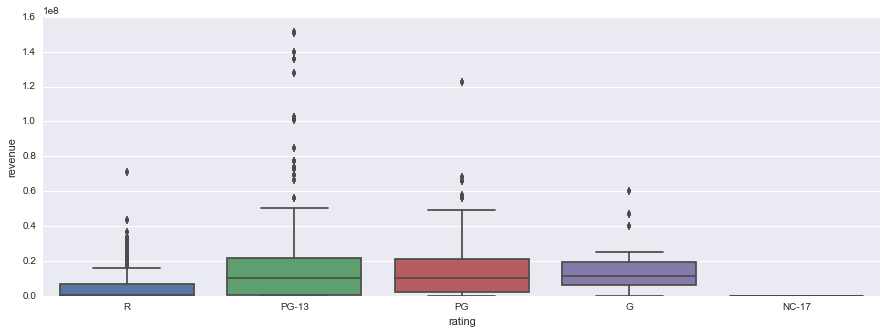

In [6]:
print('Number of review', len(df))
print('Number of movies', len(df['id'].unique()))
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
sns.boxplot(x="rating", y="revenue", data=df[df['rating'].isin({'R', 'G', 'PG', 'PG-13', 'NC-17'})])

# Let's limit to pg-13, re-percentile revenue, and take a peek at the review structure


In [7]:
df_pg13 = df[df['rating'] == 'PG-13']
print(len(df_pg13))
# Replace revenue-level through a wonky one-liner
df_pg13 = df_pg13[[c for c in df_pg13.columns if c != 'revenue_level']].join(pd.DataFrame(
        {'revenue_level': df.ix[df_pg13['id'].drop_duplicates().index].set_index('id')['revenue']
         .rank(pct=True)
         .apply(lambda x: 'High Revenue' if x > 2./3 else ('Low Revenue' if x < 1./3 else 'Mid Revenue'))}), on='id')
df_pg13.iloc[0]

1383


id                                                                 1408
revenue                                                     2.06177e+07
split                                                             train
text                  Based on a Stephen King short story that bears...
revenue percentile                                             0.854363
label                                                              True
name                                                               1408
number_of_screens                                                  2678
origin                                                              USA
rating                                                            PG-13
metadata                            1408 Rated: PG-13 Made: $20,617,667
revenue_level                                              High Revenue
Name: 7, dtype: object

# Let plot it... something's wrong.  High and low revenue movies, directors, and actors, etc. are showing up.

In [9]:
draw_plot(df_pg13, 'High Revenue', 'Low Revenue', 'revenue_level', extra='naive', minimum_term_frequency=10)

# Let's limit our term frequency count to once per document, and let's consider all reviews for a single movie one big document

In [65]:
one_movie_per_doc_df = (df_pg13.groupby(['id', 'revenue', 'revenue_level', 'rating', 'name', 'metadata'])
                        .apply(lambda x: pd.Series({'text':'\n\n\n'.join(x['text'])}))
                        .reset_index())
one_movie_per_doc_df.iloc[0]

id                                                            1408
revenue                                                2.06177e+07
revenue_level                                         High Revenue
rating                                                       PG-13
name                                                          1408
metadata                       1408 Rated: PG-13 Made: $20,617,667
text             Based on a Stephen King short story that bears...
Name: 0, dtype: object

# A PG-13 movie will probably make a lot of money if:
* Sequel or part of a franchise
* Superhero should be manly, and should kick nasty, evil bad guys
* Lots of suspenseful B-movie action sequences
* Someone should wear a memorable t-shirt
* Someone involved should be named Jerry
* Avoid strong language, but have some slapstick comedy
* Loud and dumb are probably okay, obvious may not be isn't

In [69]:
draw_plot(one_movie_per_doc_df, 'High Revenue', 'Low Revenue', 'revenue_level', 
          extra='onemoveperdoc', 
          term_ranker = st.termranking.OncePerDocFrequencyRanker, # only count one mention per document in frequency ranking
          minimum_term_frequency=8)